stanford 홈페이지에서 영화의 대한 평가 Text 데이터 가져오기
+ 버전 조정

In [ ]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2025-06-15 07:16:12--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  18.6MB/s    in 9.1s    

2025-06-15 07:16:22 (8.77 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!pip uninstall -y nltk
!pip install nltk

In [ ]:
!pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu


Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
import os; os.kill(os.getpid(), 9)

In [ ]:
!pip install transformers

In [ ]:

# 필수 라이브러리 설치 (버전 고정)

# torchtext: 텍스트 데이터 전처리 및 데이터셋 로딩 등 지원 (PyTorch 생태계)
!pip install torchtext==0.17.0 --force-reinstall

# transformers: Hugging Face에서 제공하는 사전학습 언어모델 라이브러리 (예: BERT, GPT 등)
!pip install transformers==4.38.2

# accelerate: Hugging Face에서 제공하는 학습 최적화 도구 (GPU/TPU 대응, mixed precision 등)
!pip install accelerate==0.27.2


**시드고정**

In [ ]:
import numpy as np
import torch
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

positive와 negative에 따라 label 넣기 1 or **0**

In [ ]:
import os
import pandas as pd
def load_imdb_split(split_dir):
    texts, labels = [], []
    for label in ['pos', 'neg']:
      folder = os.path.join(split_dir, label)
      for filename in os.listdir(folder):
        with open(os.path.join(folder, filename), 'r', encoding='utf-8') as f:
          texts.append(f.read())
          labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'text': texts, 'label': labels})
train_df = load_imdb_split('aclImdb/train')
test_df = load_imdb_split('aclImdb/test')

# **bert – 위 방법 외에 어떤 방법을 쓰던 sentiment classification을 하여 test set 성능을 높이기 위한 모델을 개발하고 본인의 최종 모델은 무엇이고 성능은 얼마이며 성능을 올리기 위해 어떤 것들을 수행하였는지 정리하세요. (20)**

In [ ]:

!pip install transformers



In [ ]:
# bert_imdb_classifier.py

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from transformers import BertTokenizer, BertModel

import numpy as np
import torch
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# 1. 데이터 로딩 (IMDB)
def load_imdb_split(split_dir):
    texts, labels = [], []
    for label in ['pos', 'neg']:
        folder = os.path.join(split_dir, label)
        for filename in os.listdir(folder):
            with open(os.path.join(folder, filename), 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(1 if label == 'pos' else 0)
    return pd.DataFrame({'text': texts, 'label': labels})

train_df = load_imdb_split('aclImdb/train')
test_df = load_imdb_split('aclImdb/test')

# 2. BERT 토크나이저
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# 3. Dataset 클래스 정의
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attention_mask, label

    def __len__(self):
        return len(self.texts)

# 4. DataLoader 준비
train_dataset = IMDBDataset(train_df['text'].tolist(), train_df['label'].tolist(), tokenizer)
test_dataset = IMDBDataset(test_df['text'].tolist(), test_df['label'].tolist(), tokenizer)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# **bert – 위 방법 외에 어떤 방법을 쓰던 sentiment classification을 하여 test set 성능을 높이기 위한 모델을 개발하고 본인의 최종 모델은 무엇이고 성능은 얼마이며 성능을 올리기 위해 어떤 것들을 수행하였는지 정리하세요. (20)**

In [ ]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
#다른 모델 "distilbert-base-uncased"
# 5. BERT 기반 분류 모델 정의
class BertClassifier(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.last_hidden_state
        pooled = last_hidden_state.mean(dim=1)
        logits = self.classifier(self.dropout(pooled))
        return logits.squeeze(1)

# 6. 학습 함수
def train_loop(model, train_loader, test_loader, optimizer, criterion, device, epochs=10):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_correct = 0
        print(f"\nEpoch {epoch}/{epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for batch_idx, (input_ids, attention_mask, y_batch) in progress_bar:
            input_ids, attention_mask, y_batch = input_ids.to(device), attention_mask.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predictions = (torch.sigmoid(outputs) >= 0.5).long()
            total_correct += (predictions == y_batch.long()).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_acc = total_correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader)

        # 평가
        model.eval()
        with torch.no_grad():
            correct = 0
            for input_ids, attention_mask, y_batch in test_loader:
                input_ids, attention_mask, y_batch = input_ids.to(device), attention_mask.to(device), y_batch.to(device)
                outputs = model(input_ids, attention_mask)
                preds = (torch.sigmoid(outputs) >= 0.5).long()
                correct += (preds == y_batch.long()).sum().item()

            test_acc = correct / len(test_loader.dataset)

        print(f"Epoch {epoch} Summary - Avg Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model

# 7. 학습 실행
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertClassifier(dropout=0.3)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
    mymodel=train_loop(model, train_loader, test_loader, optimizer, criterion, device, epochs=3)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]


Epoch 1/3


Training: 100%|██████████| 391/391 [19:52<00:00,  3.05s/it, loss=0.065]


Epoch 1 Summary - Avg Loss: 0.2753, Train Acc: 0.8838, Test Acc: 0.9168

Epoch 2/3


Training: 100%|██████████| 391/391 [19:48<00:00,  3.04s/it, loss=0.0819]


Epoch 2 Summary - Avg Loss: 0.1633, Train Acc: 0.9414, Test Acc: 0.9208

Epoch 3/3


Training: 100%|██████████| 391/391 [19:54<00:00,  3.06s/it, loss=0.0893]


Epoch 3 Summary - Avg Loss: 0.0935, Train Acc: 0.9688, Test Acc: 0.9175


# **모델의 가중치 저장**


In [ ]:
# 학습 코드 마지막에 추가 (예: bert_imdb_classifier.py)
torch.save(mymodel.state_dict(), "my_model.pt")

In [ ]:
import torch

# 모델 파라미터 로드
state_dict = torch.load("my_model.pt", map_location="cpu")

# 키 목록만 출력 (이름과 shape 확인)
print("🔑 모델 파라미터 키 목록:")
for i, (key, value) in enumerate(state_dict.items()):
    print(f"{i+1:>2}. {key:<50} shape: {tuple(value.shape)}")
    if i == 9:  # 상위 10개까지만 보여줌
        break


🔑 모델 파라미터 키 목록:
 1. bert.embeddings.word_embeddings.weight             shape: (30522, 768)
 2. bert.embeddings.position_embeddings.weight         shape: (512, 768)
 3. bert.embeddings.token_type_embeddings.weight       shape: (2, 768)
 4. bert.embeddings.LayerNorm.weight                   shape: (768,)
 5. bert.embeddings.LayerNorm.bias                     shape: (768,)
 6. bert.encoder.layer.0.attention.self.query.weight   shape: (768, 768)
 7. bert.encoder.layer.0.attention.self.query.bias     shape: (768,)
 8. bert.encoder.layer.0.attention.self.key.weight     shape: (768, 768)
 9. bert.encoder.layer.0.attention.self.key.bias       shape: (768,)
10. bert.encoder.layer.0.attention.self.value.weight   shape: (768, 768)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Train 데이터의 대해 단어 사전 **만들기**

In [ ]:
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from torchtext.vocab import build_vocab_from_iterator

# nltk 리소스 다운로드 (최초 1회만 필요)
nltk.download('stopwords')

# 전처리 도구 정의
stop_words  = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 예: tokenizer 정의 (split만 쓰는 경우)
tokenizer = lambda x: x.split()

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')


def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    tokens = tokenizer(text)  # 토크나이저 먼저 실행
    cleaned_tokens = [stemmer.stem(t) for t in tokens if t not in stop_words and t.isalpha() and 2 <= len(t) <= 15]
    return cleaned_tokens

from collections import Counter

all_tokens = []
for text in train_df['text']:
    all_tokens.extend(preprocess(text))
# 최소 빈도 3회 이상 필터링
word_counts = Counter(all_tokens)
vocab = {word for word, count in word_counts.items() if count >= 3}

# vocab 생성용 generator
def yield_tokens(text):
    for text in text:
        yield preprocess(text)

# vocab 생성 (train 데이터 기준)
vocab = build_vocab_from_iterator(yield_tokens(train_df['text']), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # OOV 단어는 <unk>로 처리

def head_tail(tokens, max_len=256):
    if len(tokens) <= max_len:
        return tokens
    half = max_len // 2
    return tokens[:half] + tokens[-half:]

def text_to_input_ids(text):
    tokens = preprocess(text)
    trimmed_tokens = head_tail(tokens, max_len=256)
    return [vocab[token] for token in trimmed_tokens]


# 실제로 적용
train_df['input_ids'] = train_df['text'].apply(text_to_input_ids)
test_df['input_ids'] = test_df['text'].apply(text_to_input_ids)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
len(vocab)

49710

In [ ]:
# 얼마나 많은 단어가 <unk>로 처리됐는지 비율 확인
unk_count = sum(1 for seq in test_df['input_ids'] for token in seq if token == vocab['<unk>'])
total_tokens = sum(len(seq) for seq in test_df['input_ids'])
print(f"OOV(<unk>) 비율: {unk_count / total_tokens:.2%}")

OOV(<unk>) 비율: 1.33%


사전에 따라 숫자인덱스 바꾸고 길이 **측정**

In [ ]:
# def encode_text(text):
#     tokens = tokenizer(text)
#     return vocab(tokens[:])

# train_df['input_ids'] = train_df['text'].apply(encode_text)
# test_df['input_ids'] = test_df['text'].apply(encode_text)

# lengths = [len(seq) for seq in train_df['input_ids']]
# import matplotlib.pyplot as plt
# plt.hist(lengths, bins=50); plt.title("Token Length Distribution")

토큰 시퀀스의 길이를 256으로 **제한**

Text(0.5, 1.0, 'Token Length Distribution')

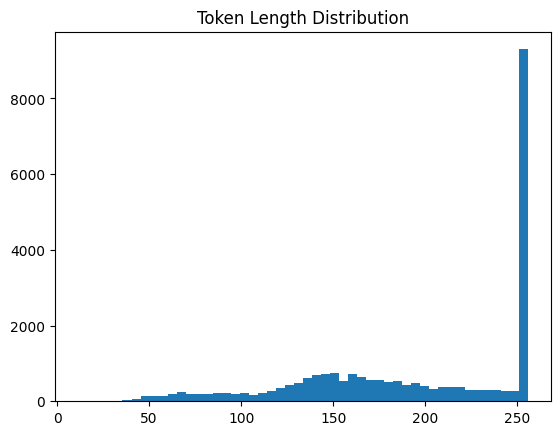

In [ ]:
# def head_tail(tokens, max_len=256):
#     if len(tokens) <= max_len:
#         return tokens
#     half = max_len // 2
#     return tokens[:half] + tokens[-half:]

# MAX_LEN=256
# def encode_text(text):
#     tokens = tokenizer(text)
#     # return vocab(tokens[:MAX_LEN])
#     return vocab(head_tail(tokens, MAX_LEN)) #앞뒤절반씩
#     # return vocab(tokens[-MAX_LEN:])                   # 뒤 기준
#     # return vocab(truncate_middle(tokens, MAX_LEN))

# def truncate_middle(tokens, max_len=256):
#     if len(tokens) <= max_len:
#         return tokens
#     start = (len(tokens) - max_len) // 2
#     return tokens[start:start + max_len]

# train_df['input_ids'] = train_df['text'].apply(encode_text)
# test_df['input_ids'] = test_df['text'].apply(encode_text)
# lengths = [len(seq) for seq in train_df['input_ids']]
# import matplotlib.pyplot as plt
# plt.hist(lengths, bins=50); plt.title("Token Length Distribution")

인덱스 시퀀스 (input_ids) → 길이 맞추기 (패딩) → 텐서로 변환 → Dataset → **DataLoader**

In [ ]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader
def create_tensor_dataset(inputs, labels):
    tensor_seqs = [torch.tensor(x) for x in inputs]
    padded_seqs = pad_sequence(tensor_seqs, batch_first=True)
    labels_tensor = torch.tensor(list(labels), dtype=torch.long)
    return TensorDataset(padded_seqs, labels_tensor)

train_dataset = create_tensor_dataset(train_df['input_ids'], train_df['label'])
test_dataset = create_tensor_dataset(test_df['input_ids'], test_df['label'])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
for batch_x, batch_y in train_loader:
    print("Input batch shape:", batch_x.shape)
    print("Example token IDs:", batch_x[0][:20])
    print("Label:", batch_y[63])
    break

Input batch shape: torch.Size([64, 256])
Example token IDs: tensor([  325,  4819,  1554,   199,   169,   474,    28,  1554,  1136,    38,
           77,    11, 21221,  5283,   493,  1777,  2013,   559,   202,     1])
Label: tensor(1)


In [ ]:
train_df['input_ids']

,input_ids
0,"[134, 2, 2454, 367, 541, 1282, 325, 148, 367, ..."
1,"[1400, 13610, 689, 4288, 799, 28827, 53, 1538,..."
2,"[176, 269, 2, 330, 31, 205, 40, 16, 17, 73, 32..."
3,"[107, 2398, 597, 215, 2, 344, 339, 237, 29, 13..."
4,"[304, 66, 850, 76, 1238, 1245, 250, 26, 35, 98..."
...,...
24995,"[16, 420, 2294, 20, 735, 115, 6, 126, 30, 1179..."
24996,"[284, 2, 349, 667, 1093, 49, 130, 7, 154, 76, ..."
24997,"[14, 838, 2, 24, 1086, 2145, 502, 89, 237, 112..."
24998,"[12, 35, 169, 2309, 64, 195, 30, 64, 68, 2, 79..."


LSTM모델 **설정**

In [ ]:
import torch.nn as nn
class SimpleLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=128, output_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim,
padding_idx=vocab["<unk>"])
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x) # (batch, seq_len, embedding_dim)
        output, (hidden, _) = self.lstm(embedded) # hidden: (1, batch, hidden_dim)
        hidden = hidden.squeeze(0) # (batch, hidden_dim)
        return self.sigmoid(self.fc(hidden))

# **bidirectional_LSTM**

In [ ]:
class SimpleLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=200, hidden_dim=64, output_dim=1, dropout_rate=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<unk>"])
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            batch_first=True,
            bidirectional=True,
            dropout=dropout_rate,
            num_layers=2  # dropout 적용되도록
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # (batch, seq_len, emb_dim)
        output, _ = self.lstm(embedded)  # (batch, seq_len, hidden_dim*2)
        pooled, _ = torch.max(output, dim=1)  # (batch, hidden_dim*2)
        pooled = self.dropout(pooled)
        return self.sigmoid(self.fc(pooled))


In [ ]:
# import torch.nn as nn

# class SimpleLSTMClassifier(nn.Module):
#     def __init__(self, vocab_size, embedding_dim=32, hidden_dim=32, output_dim=1, dropout_rate=0.25):
#         super().__init__()
#         self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=vocab["<unk>"])
#         self.dropout1 = nn.Dropout(dropout_rate)
#         self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
#         self.dropout2 = nn.Dropout(dropout_rate)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         embedded = self.embedding(x)  # (batch, seq_len, embedding_dim)
#         embedded = self.dropout1(embedded)
#         _, (hidden, _) = self.lstm(embedded)  # hidden: (1, batch, hidden_dim)
#         hidden = hidden.squeeze(0)
#         hidden = self.dropout2(hidden)
#         return self.sigmoid(self.fc(hidden))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleLSTMClassifier(vocab_size=len(vocab), embedding_dim = 200, hidden_dim =
64).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# **LSTM기반 실행 **

In [ ]:
from tqdm import tqdm
def train_loop(model, train_loader, test_loader, optimizer, criterion, device, epochs=5):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_correct = 0
        print(f"\n Epoch {epoch}/{epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")
        for batch_idx, (x_batch, y_batch) in progress_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            outputs = model(x_batch).squeeze(1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predictions = (outputs >= 0.5).long()
            total_correct += (predictions == y_batch).sum().item()
            progress_bar.set_postfix(loss=loss.item())
        train_acc = total_correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader)
        model.eval()
        with torch.no_grad():
            correct = 0
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
                outputs = model(x_batch).squeeze(1)
                preds = (outputs >= 0.5).long()
                correct += (preds == y_batch).sum().item()
            test_acc = correct / len(test_loader.dataset)

        print(f"Epoch {epoch} Summary - Avg Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    return model

In [ ]:
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)  # 예: Xavier 초기화
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

# 모델에 초기화 적용
model.apply(init_weights)

SimpleLSTMClassifier(
  (embedding): Embedding(49710, 200, padding_idx=0)
  (lstm): LSTM(200, 64, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
# model = train_loop(
# model=model,
# train_loader=train_loader,
# test_loader=test_loader,
# optimizer=optimizer,
# criterion=criterion,
# device=device,
# epochs=10
# )


 Epoch 1/10


Training: 100%|██████████| 391/391 [00:06<00:00, 62.29it/s, loss=0.244]


Epoch 1 Summary - Avg Loss: 0.5751, Train Acc: 0.6517, Test Acc: 0.8614

 Epoch 2/10


Training: 100%|██████████| 391/391 [00:06<00:00, 61.99it/s, loss=0.127]


Epoch 2 Summary - Avg Loss: 0.2469, Train Acc: 0.9043, Test Acc: 0.8641

 Epoch 3/10


Training: 100%|██████████| 391/391 [00:06<00:00, 61.48it/s, loss=0.11]


Epoch 3 Summary - Avg Loss: 0.1512, Train Acc: 0.9494, Test Acc: 0.8609

 Epoch 4/10


Training: 100%|██████████| 391/391 [00:06<00:00, 60.96it/s, loss=0.191]


Epoch 4 Summary - Avg Loss: 0.0974, Train Acc: 0.9709, Test Acc: 0.8458

 Epoch 5/10


Training:  20%|█▉        | 77/391 [00:01<00:05, 59.43it/s, loss=0.0342]


KeyboardInterrupt: 

# 모델 가중치 초기화

In [ ]:
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)  # 예: Xavier 초기화
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

# 모델에 초기화 적용
model.apply(init_weights)


SimpleLSTMClassifier(
  (embedding): Embedding(72036, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# **GloVe 사전학습 임베딩 벡터**

In [ ]:
# import os

# # 캐시 폴더 없으면 생성
# os.makedirs('/content/drive/MyDrive/glove_cache', exist_ok=True)

# # GloVe 벡터 불러오기 (최초 1회는 다운로드 후 캐시됨)
# vectors = torchtext.vocab.GloVe(name='6B', dim=300, cache='/content/drive/MyDrive/glove_cache')



In [ ]:
import torchtext
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = SimpleLSTMClassifier(vocab_size=len(vocab), embedding_dim = 300, hidden_dim =
# 128).to(device)
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# GloVe 캐시 경로를 Google Drive로 지정
vectors = torchtext.vocab.GloVe(
    name='6B',
    dim=256,
    cache='/content/drive/MyDrive/glove_cache'  # Google Drive 경로로 바꿈
)

# 사전 학습된 임베딩 가져오기
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
# model.embedding.weight.data = pretrained_embedding
# model.embedding.weight.requires_grad = True

RuntimeError: no vectors found at /content/drive/MyDrive/glove_cache/glove.6B.256d.txt

In [ ]:
model = train_loop(
model=model,
train_loader=train_loader,
test_loader=test_loader,
optimizer=optimizer,
criterion=criterion,
device=device,
epochs=10
)

NameError: name 'model' is not defined

# **PositionalEncoding**

In [ ]:
import torch
import torch.nn as nn
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) /
    d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0) # (1, max_len, d_model)
    def forward(self, x):
       return x + self.pe[:, :x.size(1)].to(x.device)

# **Using Transformer**

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, num_heads=4, hidden_dim=128,
        num_layers=2, num_classes=1, max_len=256, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        encoder_layer = nn.TransformerEncoderLayer(
        d_model=embedding_dim,
        nhead=num_heads,
        dim_feedforward=hidden_dim,
        dropout=dropout,
        batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, 1)
    def forward(self, x):
        embedded = self.embedding(x) # (batch, seq_len, emb_dim)
        encoded = self.pos_encoder(embedded)
        transformer_out = self.transformer_encoder(encoded) # (batch, seq_len, emb_dim) (2,5,4)
        pooled = transformer_out.mean(dim=1) # mean pooling (2,4)
        return self.classifier(pooled).squeeze(1) # (batch,) (2,1) -> (2,)

# **training이 되도록 고치면 성능이 형편없다. epoch, learning_rate, batch_size를 고정한채 naïve_taransformer_model 기반 모델의 test set성능을 82% 이상으로 올려보고 어떻게 성능을 향상 시켰는지 작성하세요. (20)**

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

import torch
import torch.nn as nn
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=256):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) /
    d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0) # (1, max_len, d_model)
    def forward(self, x):
       return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim=300, num_heads=4, hidden_dim=128,
        num_layers=2, num_classes=1, max_len=256, dropout=0.3, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        encoder_layer = nn.TransformerEncoderLayer(
        d_model=embedding_dim,
        nhead=num_heads,
        dim_feedforward=hidden_dim,
        dropout=dropout,
        batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(embedding_dim, 1)
    def forward(self, x):
        embedded = self.embedding(x) # (batch, seq_len, emb_dim)
        encoded = self.pos_encoder(embedded)
        transformer_out = self.transformer_encoder(encoded) # (batch, seq_len, emb_dim) (2,5,4)
        pooled = transformer_out.mean(dim=1) # mean pooling (2,4)

        return self.classifier(pooled).squeeze(1) # (batch,) (2,1) -> (2,)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vocab_size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id

naive_transformer_model = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=256,
    num_heads=8,
    hidden_dim=256,
    num_layers=4,
    pad_idx=pad_idx
).to(device)


criterion = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss로 수정

optimizer = torch.optim.Adam(naive_transformer_model.parameters(), lr=1e-4)  # model -> naive_transformer_model

from tqdm import tqdm

def train_loop(model, train_loader, test_loader, optimizer, criterion, device, epochs=5):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_correct = 0
        print(f"\n Epoch {epoch}/{epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for batch_idx, (input_ids, attention_mask, y_batch) in progress_bar:
            x_batch, y_batch = input_ids.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            outputs = model(x_batch)  # 기존 TransformerClassifier는 attention_mask 안 씀
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predictions = (outputs >= 0.5).long()
            total_correct += (predictions == y_batch).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_acc = total_correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader)

        # Evaluation
        model.eval()
        with torch.no_grad():
            correct = 0
            for input_ids, attention_mask, y_batch in test_loader:
                x_batch, y_batch = input_ids.to(device), y_batch.to(device).float()
                outputs = model(x_batch)
                preds = (outputs >= 0.5).long()
                correct += (preds == y_batch).sum().item()

            test_acc = correct / len(test_loader.dataset)

        print(f"Epoch {epoch} Summary - Avg Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model

naive_transformer_model = train_loop(
    model=naive_transformer_model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=10
)


 Epoch 1/10


Training: 100%|██████████| 391/391 [02:47<00:00,  2.33it/s, loss=0.564]


Epoch 1 Summary - Avg Loss: 0.6052, Train Acc: 0.6281, Test Acc: 0.7470

 Epoch 2/10


Training: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s, loss=0.327]


Epoch 2 Summary - Avg Loss: 0.4583, Train Acc: 0.7726, Test Acc: 0.8034

 Epoch 3/10


Training: 100%|██████████| 391/391 [02:42<00:00,  2.40it/s, loss=0.463]


Epoch 3 Summary - Avg Loss: 0.3812, Train Acc: 0.8222, Test Acc: 0.7898

 Epoch 4/10


Training: 100%|██████████| 391/391 [02:42<00:00,  2.40it/s, loss=0.36]


Epoch 4 Summary - Avg Loss: 0.3465, Train Acc: 0.8441, Test Acc: 0.8317

 Epoch 5/10


Training: 100%|██████████| 391/391 [02:40<00:00,  2.44it/s, loss=0.295]


Epoch 5 Summary - Avg Loss: 0.3117, Train Acc: 0.8606, Test Acc: 0.8364

 Epoch 6/10


Training: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s, loss=0.34]


Epoch 6 Summary - Avg Loss: 0.2791, Train Acc: 0.8825, Test Acc: 0.8314

 Epoch 7/10


Training: 100%|██████████| 391/391 [02:39<00:00,  2.46it/s, loss=0.215]


Epoch 7 Summary - Avg Loss: 0.2532, Train Acc: 0.8926, Test Acc: 0.8090

 Epoch 8/10


Training:  17%|█▋        | 68/391 [00:27<02:13,  2.43it/s, loss=0.248]

### 새로운 실행코드

In [ ]:


from tqdm import tqdm

def train_loop(model, train_loader, test_loader, optimizer, criterion, device, epochs=5):
    model.to(device)
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_correct = 0
        print(f"\n Epoch {epoch}/{epochs}")
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for batch_idx, (x_batch, y_batch) in progress_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
            optimizer.zero_grad()
            outputs = model(x_batch)  # ⬅️ squeeze 제거
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            predictions = (outputs >= 0.5).long()
            total_correct += (predictions == y_batch).sum().item()
            progress_bar.set_postfix(loss=loss.item())

        train_acc = total_correct / len(train_loader.dataset)
        avg_loss = total_loss / len(train_loader)

        # Evaluation
        model.eval()
        with torch.no_grad():
            correct = 0
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device).float()
                outputs = model(x_batch)  # ⬅️ squeeze 제거
                preds = (outputs >= 0.5).long()
                correct += (preds == y_batch).sum().item()

            test_acc = correct / len(test_loader.dataset)

        print(f"Epoch {epoch} Summary - Avg Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

    return model


In [ ]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())
naive_transformer_model.embedding.weight.data = pretrained_embedding
naive_transformer_model.embedding.weight.requires_grad = True


# **가중치 초기화**

In [ ]:
import torch.nn as nn

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)  # 예: Xavier 초기화
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)

# 모델에 초기화 적용
naive_transformer_model.apply(init_weights)

TransformerClassifier(
  (embedding): Embedding(49710, 256, padding_idx=0)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (classifier): Linear(in_features=256, out_features=1, bias=True)
)